In [22]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize_scalar
from tqdm import tqdm

In [23]:
#Definindo função objetivo

def f(x):
    R = 0.985
    gamma = 1000
    D = 22
    beta_1 = 2
    beta_2 = 2
    
    #Como estava dando muito overflow, foi orientado a colocar uma penalização

    penal = (1e6)*(max(0, -x[0]) + max(0, - x[1] ) + max(0, x[0] - 1) + max(0, x[1] - 1))
    
    if(penal>0):
        return penal
    else:
        f1 = (1-R)*((D)/(10*(1+beta_1)-x[0]))*np.exp((10*x[0])/(1+((10*x[0])/(gamma))))-x[0]
        f2 = x[0]-(1+beta_2)*x[1]+(1-R)*(((D)/(10))-beta_1*x[0]-(1+beta_2)*x[1])*np.exp((10*x[1])/(1+((10*x[1])/(gamma))))
        
        return (f1**2 + f2**2)

In [24]:
#Print para garantir que está alocado corretamente na memória

x0 = [0.5, 0.5]
print(f(x0))

3.9804030995425403


In [25]:
#Definindo funções com derivadas (df, d2f, gradient e hessiana)
#definir função gradiente sem argumento de h... fica muito longo e muito chato de escrever
def df(x,m):
    h = 0.001
    dim = len(x)
    a = np.zeros(dim)
    b = np.zeros(dim)
    
    for i in range(dim):
        if i==m:
            a[i] = x[i] + h
            b[i] = x[i] - h
        else:
            a[i] = x[i]
            b[i] = x[i]
    return (f(a) - f(b))/(2*h)

def d2f(x, m, n):
    h = 0.001
    dim = len(x)
    a = np.zeros(dim)
    b = np.zeros(dim)
    
    for i in range(dim):
        if i==m:
            a[i] = x[i] + h
            b[i] = x[i] - h
        else:
            a[i] = x[i]
            b[i] = x[i]
    return (df(a, n) - df(b, n))/(2*h)

    

def gradient(x):
    dim = len(x)
    
    v = np.zeros(dim)
    for i in range(dim):
        v[i] = df(x, i)
    return v

def hessiana(x):
    dim = len(x)
    H = np.zeros((dim, dim))
    for i in range(dim):
        for j in range(dim):
            H[i, j] = d2f(x, i, j)
    return H
    

In [26]:
gradient(x0)
#printou, tá show

array([44.82532696, 52.73316676])

In [27]:
#Definindo variáveis globais a todos os métodos (max_iter e tol)
max_iter = 1000
tol = 1e-10

In [28]:
#Método de Newton

def Newton(x, grad, hess, max_iter, tol):
    tabela = []
    dim = len(x)
    Err = list()
    
    for i in range(max_iter//10):
        grad = gradient(x)
        hess = hessiana(x)
        
        
        try:
            inv_H = np.linalg.inv(hess)
        except np.linalg.LinAlgError:
            break
        
        inv_H = np.linalg.inv(hess)
        tabela.append([i, x, f(x)])
        x = x - np.dot(grad, inv_H)
        
        err = np.linalg.norm(grad)
        Err.append(err)
        
        if err < tol: #Critério de parada
            break
           
    return x
    #return tabela

In [29]:
Newton([0.5, 0.2], gradient(x0), hessiana(x0), max_iter, tol)

array([0.34441905, 0.1363054 ])

In [30]:
#Método de Stepeest Descent

def SteepestDescent(x, max_iter, tol): #deixarei como argumento caso queira mudar os parâmetro para ver o comportamento do método
    tabela = []
    n = 1
    for n in range(max_iter):
        grad = gradient(x)
        if np.linalg.norm(grad)<tol:#critério de parada
            tabela.append([n, x, f(x)])
            #tabela.append([n, x, f(x), np.linalg.norm(grad)]) - Opção para tabela
            break
        d = -grad
        
        lambida_i = lambda alpha: f(x + alpha*d)
        lambida_resultado = minimize_scalar(lambida_i)
        lambida_1 = lambida_resultado.x
        tabela.append([tabela.append([n, x, f(x)])])
        
        x = x + lambida_1*d
        n = n+1
    return x    
    #return tabela

In [31]:
SteepestDescent([0.5, 0.2], max_iter, tol)
#Printou também

array([0.34442483, 0.13631017])

In [32]:
def DFP1(x, max_iter, tol):
    tabela = []
    dim = len(x)
    D = np.identity(dim)
    y = x
    
    
    
    for k in range(max_iter +1):
        grad = gradient(y)
        norma = np.linalg.norm(grad)
        
        
        if norma <tol:
            break
        elif f(y) < tol:
            break
        else:
            lambida_i = lambda alpha: f(x + alpha*d)
            lambida_resultado = minimize_scalar(lambida_i)
            lambida_1 = lambida_resultado.x
            #tabela.append([tabela.append([n, x, f(x)])]) - Veio na cópia da célula acima
            
            yp1 = y + lambida_1 *d
            
            #inicializando as matrizes e vetores do método
            if(k%(len(x))==0):
                p = yp1 - y
                q = gradient(yp1) - gradient(y)
                
                numerador1 = np.outer(p, p)
                denominador1 = np.outer(p, q)
                
                numerador2 = np.outer(q, q)
                denominador2 = np.dot(q, D @ q)
                
                D = D + numerador1/denominador1 - numerador2/denominador2
                
            tabela.append([k, y, grad])
            
            y = yp1
        return y

In [33]:
def DFP2(x, max_iter, tol):
    dim = len(x)
    tabela = []
    D = np.identity(dim)
    y = x
    
    j = 0
    
    
    for k in range(max_iter):
        
        if j<dim:
            #Critérios de Parada (são dois... uau)
            if np.linalg.norm(gradient(y)) <tol:
                break
            elif f(y) < tol:
                break
            else:
                d = -np.dot(D, gradient(y))
                
                lambida_i = lambda alpha: f(x + alpha*d)
                lambida_resultado = minimize_scalar(lambida_i)
                lambida_1 = lambida_resultado.x
                
                yp1 = y + lambida_1*d
                
                
                
                p = yp1 - y
                q = gradient(yp1) - gradient(y)
                
                #Com o np.outer estava dando problema
                numerador1 = np.outer(p, p.transpose())
                denominador1 = np.dot(p.transpose(), q)
                
                numerador2 = np.dot(np.dot(D,q),np.dot(q.transpose(), D))
                denominador2 = np.dot(np.dot(q.transpose(), D), q)
                
                
                D = D + numerador1/denominador1 - numerador2/denominador2
                tabela.append([k, y, yp1, f(y), np.linalg.norm(gradient(y))])
                
                y = yp1
                j = j + 1
            if j == dim:
                y = yp1
                xp1 = yp1
                k = k + 1
                j = 0
            
            
    return tabela
    
                
                
    

In [34]:
DFP2([0.5, 0.2], 10, 1e-6)

/home/servidor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/home/servidor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars


[[0,
  [0.5, 0.2],
  array([0.35830533, 0.19924221]),
  1.2542535415420106,
  33.7315758408066],
 [1,
  array([0.35830533, 0.19924221]),
  array([0.21715086, 0.19997193]),
  0.021657369866088242,
  0.672676640934372],
 [2,
  array([0.21715086, 0.19997193]),
  array([0.06839354, 0.17842656]),
  0.079069718548929,
  1.11152376579849],
 [3,
  array([0.06839354, 0.17842656]),
  array([-0.07331654,  0.0765921 ]),
  0.11161715673050376,
  1.3495948135836167],
 [4,
  array([-0.07331654,  0.0765921 ]),
  array([-0.21256031, -0.02901846]),
  73316.54189497644,
  1000000.0],
 [5,
  array([-0.21256031, -0.02901846]),
  array([-0.329478  , -0.16436641]),
  241578.7648885293,
  1414213.562373095],
 [6,
  array([-0.329478  , -0.16436641]),
  array([nan, nan]),
  493844.4095150573,
  1414213.562373095],
 [7, array([nan, nan]), array([nan, nan]), nan, nan],
 [8, array([nan, nan]), array([nan, nan]), nan, nan],
 [9, array([nan, nan]), array([nan, nan]), nan, nan]]

In [35]:
def DFP3(x, max_iter, tol):
    dim = len(x)
    tabela = []
    D = np.identity(dim)
    
    y = x
   
    j = 0
    for k in range(max_iter):
        if j<dim:
            grad = gradient(y)
            norma = np.linalg.norm(grad)
            #print("Primeiro if\n")
        
            if norma <tol or f(y)<tol:#Critério de parada
                print("Acabou aqui!\n")
                break
        
            d = -np.dot(grad, D)
        
            lambida_i = lambda alpha: f(y+ alpha*d)
            lambida_resultado = minimize_scalar(lambida_i)
            lambida_1 = lambida_resultado.x
        
            yp1 = y + lambida_1*d
            p = yp1 - y
            q = gradient(yp1) - gradient(y)
            numerador1 = np.outer(p, p.transpose())
            denominador1 = np.dot(p.transpose(), q)
                
            numerador2 = np.dot(np.dot(D,q),np.dot(q.transpose(), D))
            denominador2 = np.dot(np.dot(q.transpose(), D), q)
                
            D = D + numerador1/denominador1 - numerador2/denominador2
            
            
            tabela.append([k, y, grad, norma, f(y)])
            #print("Segundo if\n")
        
        if j==dim:
            j = 0
                            
            tabela.append([k, y, grad, norma, f(y)])
            #print("Terceiro if\n")
            
        j = j + 1
        y = yp1
            
    return tabela
                
            
            

In [36]:
DFP3([0.1, 0.1], max_iter, tol)

[[0,
  [0.1, 0.1],
  array([-0.14218049,  0.63573874]),
  0.6514438065270147,
  0.022000393904196],
 [1,
  array([0.009966  , 0.50257355]),
  array([-0.00334581, -0.00067499]),
  0.003413213139529547,
  4.804314659948949e-06],
 [2,
  array([0.00997361, 0.50261026]),
  array([-0.00334581, -0.00067499]),
  0.003413213139529547,
  4.777855550097948e-06],
 [3,
  array([0.00997361, 0.50261026]),
  array([-0.0044574 ,  0.00099723]),
  0.004567590009263057,
  4.777855550097948e-06],
 [4,
  array([0.01000013, 0.50266382]),
  array([-0.0044574 ,  0.00099723]),
  0.004567590009263057,
  4.743530943725586e-06],
 [5,
  array([0.01000013, 0.50266382]),
  array([-0.00568875,  0.00288865]),
  0.006380142236414936,
  4.743530943725586e-06],
 [6,
  array([0.01007676, 0.50276648]),
  array([-0.00568875,  0.00288865]),
  0.006380142236414936,
  4.67022604743904e-06],
 [7,
  array([0.01007676, 0.50276648]),
  array([-0.00739308,  0.0055899 ]),
  0.009268470392497377,
  4.67022604743904e-06],
 [8,
  array(

In [54]:
def DFP(x, tolerancia=1e-6, numero_max_de_iteracoes=100):
    tabela = []
    dim = len(x)
    D = np.identity(dim)
    y = x
    k = 1
    n = len(x)
    loop = True

    while k < numero_max_de_iteracoes and loop:

        j = 1

        while j <= n:

            gradiente = gradient(y)
            norma = np.linalg.norm(gradiente)

            if norma < tol or f(y) < tol: 
                loop = False

            d = - np.dot(gradiente, D)

            lambda_i = lambda alpha: f(y + alpha * d )
            lambda_1_result = minimize_scalar(lambda_i)
            lambda_1 = lambda_1_result.x

            y1 = y + lambda_1 * d 


            if j == n:
                p = y1 - y
                q = gradient(y1) - gradient(y)

                Numerador1 = np.dot(p, np.transpose(p))
                Denominador1= np.dot(np.transpose(p),q)

                Numerador2 = np.dot(np.dot(D,q),np.dot(np.transpose(q),D))
                Denominador2 = np.dot(np.dot(np.transpose(q),D),q)

                D = D + (Numerador1/Denominador1) - (Numerador2/Denominador2)

            tabela.append([k , y , j , gradiente, norma , D, d])

            j +=1

            y = y1
    
        k+=1
    
    return y




In [38]:
n = 200
Z = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        fi = np.array([x[i], y[j]])
        Z[i, j] = f([x[i], y[j])

SyntaxError: invalid syntax (<ipython-input-38-56debefd4cbb>, line 6)

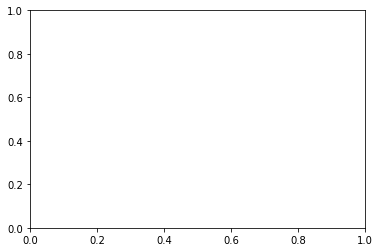

In [39]:
fig, ax = plt.subplots()

In [40]:
surf = ax.contour(X, Y, Z, 50)

NameError: name 'X' is not defined

In [41]:
S = np.array([[0.012223, 0.016625], [0.012223, 0.504131], [0.012223, 0.666204], [0.496354, 0.186263], [0.680842, 0.233986]])

In [42]:
D = {0: list(), 1: list(), 2: list(), 3: list(), 4: list(), 5:list()}

In [43]:
for i in tqdm(range(n)):
    for j in range(n):
        x0 = np.array(x[i], y[j])
        resultado = DFP3(x0, max_iter, tol)
        conv = False
        
    for k, s in enumerate(S):
        if np.linalg.norm(s - resultado) < tol:
            conv = True
            D[k].append(x0)
    if not conv:
        D[5].append(x0)

NameError: name 'n' is not defined

In [44]:
for i in tqdm(range(n)):
    for j in range(n):
        x0 = np.array([x[i], y[j]])
        resultado = DFP3(x0, max_iter, tol)

        conv = False

        for k, s in enumerate(S):
            if np.linalg.norm(s - resultado) < 1e-3:
                conv = True
                D[k].append(x0)
        if not conv:
            D[5].append(x0)

print("-----------------QUANTIDADE DOS QUE CONVERGERAM PARA CADA SOLUÇÃO------------------------")
print("Solução 1:",len(D[0]))

print("Solução 2:",len(D[1]))

print("Solução 3:", len(D[2]))

print("Solução 4:",len(D[3]))

print("Solução 5:",len(D[4]))

print("Nenhum:",len(D[5]))


C = {0: "blue", 1: "red", 2: "yellow", 3: "green", 4: "pink", 5: "black"}

for k, d in enumerate(D.values()):
    if len(d) > 0:
        d = np.array(d)
        if k != 5:
            plt.plot(d[:, 0], d[:, 1], linewidth=0.0, marker="o", markersize=2, color=C[k], label=f'Convergiu para solução {k+1}')
        else:
            plt.plot(d[:, 0], d[:, 1], linewidth=0.0, marker="o", markersize=2, color=C[k], label='Não convergiu para nenhuma solução')

plt.legend(fontsize=6)

plt.title("Bacia de atração usando Método de DFP")
plt.show()




NameError: name 'n' is not defined


  0%|          | 0/200 [00:00<?, ?it/s]/home/servidor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars

 17%|█▋        | 34/200 [10:02<54:44, 19.79s/it]

KeyboardInterrupt: 

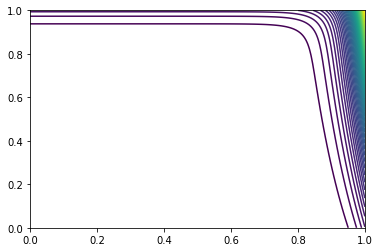

In [55]:


n = 200

x = np.linspace(start=0, stop=1, num=n)
y = np.linspace(start=0, stop=1, num=n)

X, Y = np.meshgrid(x, y)

Z = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        phi = np.array([x[i], y[j]])
        Z[i, j] = f(phi)


fig, ax = plt.subplots()

from matplotlib import cm 
surf = ax.contour(X, Y, Z, 50)

S = np.array([[0.012223, 0.016625], [0.012223, 0.504131], [0.012223, 0.666204], [0.496354, 0.186263], [0.680842, 0.233986]])

D = {0: list(), 1: list(), 2: list(), 3: list(), 4: list(), 5: list()}

for i in tqdm(range(n)):
    for j in range(n):
        x0 = np.array([x[i], y[j]])
        resultado = DFP(x0)

        conv = False

        for k, s in enumerate(S):
            if np.linalg.norm(s - resultado) < 1e-3:
                conv = True
                D[k].append(x0)

        if not conv:
            D[5].append(x0)

print("-----------------QUANTIDADE DOS QUE CONVERGERAM PARA CADA SOLUÇÃO------------------------")
print("Solução 1:",len(D[0]))

print("Solução 2:",len(D[1]))

print("Solução 3:", len(D[2]))

print("Solução 4:",len(D[3]))

print("Solução 5:",len(D[4]))

print("Nenhum:",len(D[5]))


C = {0: "blue", 1: "red", 2: "yellow", 3: "green", 4: "pink", 5: "black"}

for k, d in enumerate(D.values()):
    if len(d) > 0:
        d = np.array(d)
        if k != 5:
            plt.plot(d[:, 0], d[:, 1], linewidth=0.0, marker="o", markersize=2, color=C[k], label=f'Convergiu para solução {k+1}')
        else:
            plt.plot(d[:, 0], d[:, 1], linewidth=0.0, marker="o", markersize=2, color=C[k], label='Não convergiu para nenhuma solução')

plt.legend(fontsize=6)

plt.title("Bacia de atração usando Método de DFP")
plt.show()


  6%|▌         | 11/200 [00:11<02:27,  1.28it/s]

KeyboardInterrupt: 

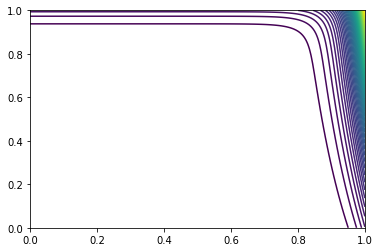

In [46]:
n = 200

# Definição do vetor x.
x = np.linspace(start=0, stop=1, num=n)
# Definição do vetor y.
y = np.linspace(start=0, stop=1, num=n)


X, Y = np.meshgrid(x, y)


Z = np.zeros((n, n))



for i in range(n):
    
    for j in range(n):
        
        phi = np.array([x[i], y[j]])
        
        Z[i, j] = f(phi)


fig, ax = plt.subplots()


from matplotlib import cm 

surf = ax.contour(X, Y, Z, 50)

S = np.array([[0.012223, 0.016625], [0.012223, 0.504131], [0.012223, 0.666204], [0.496354, 0.186263], [0.680842, 0.233986]])

D = {0: list(), 1: list(), 2: list(), 3: list(), 4: list(), 5: list()}

for i in tqdm(range(n)):
    for j in range(n):
        x0 = np.array([x[i], y[j]])
        resultado = Newton(x0, gradient, hessiana, max_iter, tol)

        conv = False

        for k, s in enumerate(S):
            if np.linalg.norm(s - resultado) < 1e-3:
                conv = True
                D[k].append(x0)

        if not conv:
            D[5].append(x0)

print("-----------------QUANTIDADE DOS QUE CONVERGERAM PARA CADA SOLUÇÃO------------------------")
print("Solução 1:",len(D[0]))

print("Solução 2:",len(D[1]))

print("Solução 3:", len(D[2]))

print("Solução 4:",len(D[3]))

print("Solução 5:",len(D[4]))

print("Nenhum:",len(D[5]))


C = {0: "blue", 1: "red", 2: "yellow", 3: "green", 4: "pink", 5: "black"}

for k, d in enumerate(D.values()):
    if len(d) > 0:
        d = np.array(d)
        if k != 5:
            plt.plot(d[:, 0], d[:, 1], linewidth=0.0, marker="o", markersize=2, color=C[k], label=f'Convergiu para solução {k+1}')
        else:
            plt.plot(d[:, 0], d[:, 1], linewidth=0.0, marker="o", markersize=2, color=C[k], label='Não convergiu para nenhuma solução')

plt.legend(fontsize=6)

plt.title("Bacia de atração usando Método de Newton")
plt.show()




  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:08<01:13,  8.21s/it]

 20%|██        | 2/10 [00:15<01:03,  7.92s/it]

 30%|███       | 3/10 [00:23<00:55,  7.97s/it]

 40%|████      | 4/10 [00:30<00:46,  7.77s/it]

 50%|█████     | 5/10 [00:38<00:38,  7.78s/it]

 60%|██████    | 6/10 [00:46<00:31,  7.81s/it]

 70%|███████   | 7/10 [00:54<00:23,  7.75s/it]

 80%|████████  | 8/10 [01:02<00:15,  7.93s/it]

 90%|█████████ | 9/10 [01:10<00:07,  7.82s/it]

100%|██████████| 10/10 [01:18<00:00,  7.86s/it]



-----------------QUANTIDADE DOS QUE CONVERGERAM PARA CADA SOLUÇÃO------------------------
Solução 1: 17
Solução 2: 13
Solução 3: 1
Solução 4: 0
Solução 5: 0
Nenhum: 69


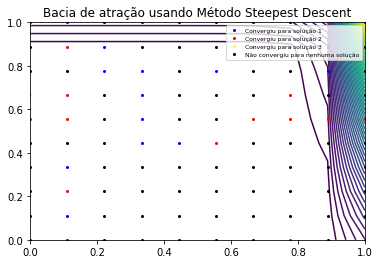

[[0.012223 0.016625]
 [0.012223 0.504131]
 [0.012223 0.666204]
 [0.496354 0.186263]
 [0.680842 0.233986]]


In [57]:
n = 10

x = np.linspace(start=0, stop=1, num=n)
y = np.linspace(start=0, stop=1, num=n)

X, Y = np.meshgrid(x, y)

Z = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        phi = np.array([x[i], y[j]])
        Z[i, j] = f(phi)

fig, ax = plt.subplots()

from matplotlib import cm 
surf = ax.contour(X, Y, Z, 50)

S = np.array([[0.012223, 0.016625], [0.012223, 0.504131], [0.012223, 0.666204], [0.496354, 0.186263], [0.680842, 0.233986]])

D = {0: list(), 1: list(), 2: list(), 3: list(), 4: list(), 5: list()}

for i in tqdm(range(n)):
    for j in range(n):
        x0 = np.array([x[i], y[j]])
        resultado = SteepestDescent(x0, max_iter, tol)

        conv = False

        for k, s in enumerate(S):
            if np.linalg.norm(s - resultado) < 1e-3:
                conv = True
                D[k].append(x0)

        if not conv:
            D[5].append(x0)

print("-----------------QUANTIDADE DOS QUE CONVERGERAM PARA CADA SOLUÇÃO------------------------")
print("Solução 1:",len(D[0]))

print("Solução 2:",len(D[1]))

print("Solução 3:", len(D[2]))

print("Solução 4:",len(D[3]))

print("Solução 5:",len(D[4]))

print("Nenhum:",len(D[5]))


C = {0: "blue", 1: "red", 2: "yellow", 3: "green", 4: "pink", 5: "black"}

for k, d in enumerate(D.values()):
    if len(d) > 0:
        d = np.array(d)
        if k != 5:
            plt.plot(d[:, 0], d[:, 1], linewidth=0.0, marker="o", markersize=2, color=C[k], label=f'Convergiu para solução {k+1}')
        else:
            plt.plot(d[:, 0], d[:, 1], linewidth=0.0, marker="o", markersize=2, color=C[k], label='Não convergiu para nenhuma solução')

plt.legend(fontsize=6)

plt.title("Bacia de atração usando Método Steepest Descent")
plt.show()
print(S)

In [ ]:
print(S)

In [ ]:
for i in tqdm(range(n)):
    for j in range(n):
        x0 = np.array([x[i], y[j]])
        resultado = Newton(x0, gradient, hessiana, tol, max_iter)

        conv = False
        for k, s in enumerate(S):
            if norm(s - resultado) < 1e-3:
                conv = True
                D[k].append(x0)

        if not conv:
            D[5].append(x0)